# Transmission Loss

In this tutorial, we will show how Kadlu can help us calculate the trasmission loss of sound in the ocean. For this purpose, we will use a realistic marine environment know as The Gully, located 200 km off the coast of Nova Scotia.

### Background info about The Gully
"The Gully is located approximately 200 kilometres off Nova Scotia to the east of Sable Island on the edge of the Scotian Shelf. Over 65 kilometres long and 15 kilometres wide, the Gully is the largest underwater canyon in the western North Atlantic. The movement of glaciers and meltwater erosion formed the canyon approximately 150,000 to 450,000 years ago, when much of the continental shelf was above the current sea level.

The Gully ecosystem encompasses shallow sandy banks, a deep-water canyon environment, and portions of the continental slope and abyssal plain, providing habitat for a wide diversity of species. The Gully’s size, shape, and location have an effect on currents and local circulation patterns, concentrating nutrients and small organisms within the canyon.

The Gully is home to the endangered Scotian Shelf population of Northern bottlenose whales and is an important habitat for 15 other species of whales and dolphins. Tiny plankton, a variety of fish such as sharks, tunas and swordfish, and seabirds inhabit surface waters, while halibut, skates, cusk and lanternfish can be found as deep as one kilometre. The ocean floor supports crabs, sea pens, anemones, brittle stars, and approximately 30 species of cold-water."

(Source: www.dfo-mpo.gc.ca)

We begin by importing the necessary modules, functions, etc.

In [1]:
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from kadlu.geospatial.ocean import Ocean
from kadlu.plot_util import plot2D
from kadlu.sound.geophony import transmission_loss

## Fetch and load environmental data

The geographical and temporal boundaries are specified as python dictionary, to be used later for fetching and loading the necessary environmental data. In this example, we are concerned with the area extending from $43.53^{\circ}$N to $44.29^{\circ}$N and $-59.84^{\circ}$W to $-58.48^{\circ}$W, on January 1, 2015.

In [2]:
# ocean boundaries
bounds = dict(
               south=43.53, north=44.29, west=-59.84, east=-58.48,
               start=datetime(2015,1,1), end=datetime(2015,1,2), 
               top=0, bottom=10000
             )

We proceed to fetching and loading the environmental data. This is accomplished with the Ocean class, as shown below. We fetch bathymetry data from the Canadian Hydrographic Service (CHS) and temperature/salinity data from the HYbrid Coordinate Ocean Model (HYCOM).

In [3]:
# data sources
data_sources = dict(load_bathymetry='chs', load_temp='hycom', load_salinity='hycom')

# initialize Ocean instance
gully = Ocean(**bounds, **data_sources)

We can use Kadlu's plot2D method to display the bathymetry (i.e. seafloor depth) in the selection region:

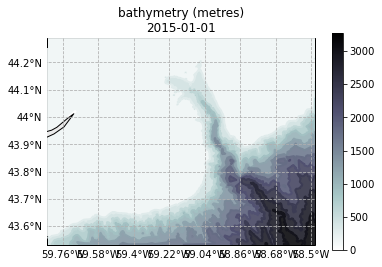

In [4]:
plot2D(var='bathy', source='chs', **bounds)

The transition from the light (shallow) to dark (deep) colors demarks the edge of the continental shelf. The Gully is seen running north south in the right side of the figure, while the eastern tip of Sable Island is visible near the left edge of the figure. 

## Calculate transmission loss

Having fetched all the necessary environmental data, we can proceed to calculating the transmission loss. 

At present, Kadlu does not provide seafloor lithology data. Therefore, the acoustic properties of the seafloor must be specified manually. Here, we assume a sound speed of 1,700 m/s, a density of 1.5 g/cm$^3$ and an attenuation of 0.5 dB/$\lambda$.

In [5]:
# specify bottom acoustic properties
seafloor = {'sound_speed':1700,'density':1.5,'attenuation':0.5}

For the sound source, we assume a omni-directional, point-like source with a frequency of 200 Hz, sitting 12 m below the sea surface and located about 10 km east of The Gully at $-43.9^{\circ}$N and $-59.2^{\circ}$W. 

In [6]:
sound_source = {'freq': 200, 'lat': 43.9, 'lon': -59.2, 'source_depth': 12}

We now compute the transmission loss out to a range of 30 km.

In [7]:
# initialize transmission loss object
transm_loss = transmission_loss(seafloor=seafloor, 
                                propagation_range=30, 
                                **sound_source,
                                **bounds, 
                                **data_sources)

# calculate transmission loss (be patient, this may take a while ...)
_ = transm_loss.calc(rec_depth=[0.1, 30], vertical=True, nz_max=1000)

100%|██████████| 4000/4000 [01:44<00:00, 38.20it/s]


We begin by inspecting the transmission loss in the $z$-$r$ plane, in an easternly direction from the source (angle=0$^{\circ}$). Here, $z$ denotes the elevation and $r$ the distance.

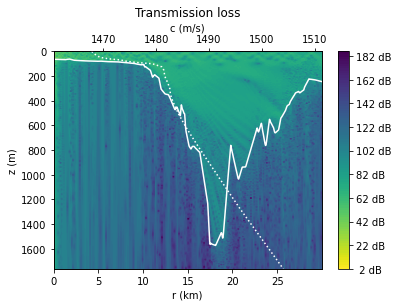

In [8]:
#transmission loss with bathy and ssp superimposed
fig = transm_loss.plot_vert(angle=0, max_depth=1770, show_ssp=True)

In the above figure, the solid white line shows the bathymetry while the dotted line shows the sound speed at the deepest location.

We can also visualize the transmission loss in the horizontal plane, at any of the depths where we positioned our receivers. For example, 

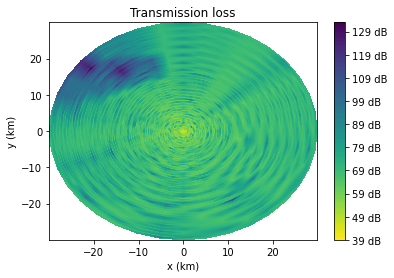

In [9]:
fig = transm_loss.plot_horiz(rec_depth_idx=1)  # transmission loss at 30 m depth (receiver no. 2)

## Transmission Loss in a Homogeneous Halfspace

We can also use Kadlu to compute the transmission loss in an highly simplified, model environment. Such computations can help us gain an intuitive understanding of sound propagation in the ocean, while also providing useful benchmark of the accuracy and speed of the code. Here, we will consider a point-like source near the surface in a homogeneous halfspace.

We assume the source to be located 75 m below the surface and to be emitting omni-directional sound at a frequency of 100 Hz. The seafloor depth is set to 2 km; the precise value is not important as we will only consider propagation down to 500 m depth and out to a range of 500 m from the source. Finally, we assume a uniform sound speed of 1480 m/s.

100%|██████████| 33/33 [00:00<00:00, 165.69it/s]


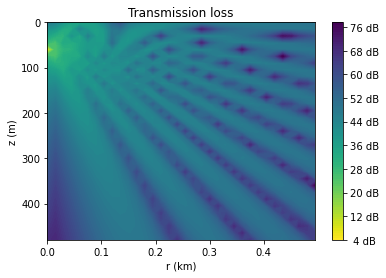

In [10]:
transm_loss = transmission_loss(freq=100, source_depth=75, propagation_range=0.5, 
                                load_bathymetry=2000, ssp=1480)

# calculate transmission loss
_ = transm_loss.calc(vertical=True)

# plot
fig = transm_loss.plot_vert(angle=0, max_depth=500)

This pattern compares very well with that seen in Fig.6.4 in Jensen's Computational Ocean Acoustics book.